In [1]:
import sys
sys.path.append('/global/homes/k/kunhaoz/des/projects/jax_cosmo_late_mod/')
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
%pylab inline
import os.path
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.10'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
import jax
import jax.numpy as np
import jax_cosmo as jc

# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=0
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false
# %env XLA_PYTHON_CLIENT_ALLOCATOR=platform
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=.30

#%env

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Exercice: WL + Galaxy-Clustering $C_\ell$

# Retrieving the nz data

In [3]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

In [4]:
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.10'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                            nz_lens['BIN%d'%i].astype('float32'), bw=0.01, zmax=1)
        for i in range(1,6)]    

I0000 00:00:1696111103.744872 1822090 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2023-09-30 14:58:25.285663: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:447] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-09-30 14:58:25.285711: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:451] Memory usage: 84550746112 bytes free, 84990623744 bytes total.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

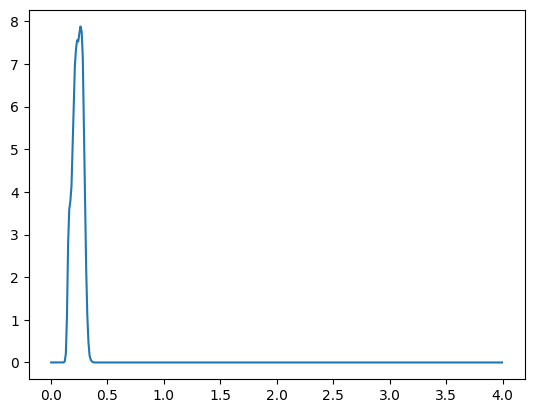

In [5]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false



z = linspace(0,1.2)
#fig,axs=plt.subplots(1,5,figsize=(15,5))
for i in range(5):
    plot(nz_lens['Z_MID'], nz_lens['BIN%d'%(i+1)], color='C%d'%i, label=f'FITS BIN[{i}]')
    plot(z, nzs_l[i](z), '--', color='C%d'%i, label='jc kde')
    xlim(0,1.2);
#legend()
title('Lens redshift distributions');

# Let's build a model for C_ell

In [ ]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

def get_params_vec(cosmo, m, dz, ia, bias):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    b1, b2, b3, b4, b5 = bias
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta,
        # linear galaxy bias
        b1, b2, b3, b4, b5
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    bias = params[16:21]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta], bias



# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.], [1.,2.,3.,4.,5.])
print(unpack_params_vec(p))

In [ ]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=2.0) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)

    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 

    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]

    
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl, probes

In [ ]:
print("le nombre de ell:",ell.shape)

In [ ]:
#f_sky = 1321./41253.
f_sky = 0.25
print("f_sky", f_sky)

@jax.jit
def cov(params):
    
    cl_signal, probes = mu(params)
        
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)
    
    return cov

In [ ]:
def cl_mean(p):
    cl,_ = mu(p)
    return cl.flatten()
jacobian = jax.jit(jax.jacfwd(lambda p: cl_mean(p)))

In [ ]:
# Let's try it out
from functools import partial

FiducialCosmo = partial(jc.Cosmology, sigma8=0.801,
                         Omega_c=0.2545,
                         Omega_b=0.0485,
                         h=0.682,
                         n_s=0.971,
                         w0=-1., Omega_k=0., wa=0.)

fid_cosmo = FiducialCosmo()

fid_params = get_params_vec(fid_cosmo, 
                            [0., 0., 0., 0.],
                            [0., 0., 0., 0.],
                            [0.5, 0.],
                            [1.2, 1.4, 1.6, 1.8, 2.0])

In [ ]:
unpack_params_vec(fid_params )

In [ ]:
cl_wlnc,_ = mu(fid_params)

In [ ]:
cl_wlnc.shape

In [ ]:
for i in range(cl_wlnc.shape[0]):
    loglog(ell, cl_wlnc[i])

In [ ]:
semilogy(cl_wlnc.flatten())

In [ ]:
#np.save('JEC_desy1_mock_data.npy',cl_wlnc.flatten())

In [ ]:
#data = np.load('JEC_desy1_mock_data.npy')

In [ ]:
C = cov(fid_params)

In [ ]:
C.shape

In [ ]:
j = jacobian(fid_params)

In [ ]:
j.shape

In [ ]:
# And we get the fisher matrix from the jacobian and covariance
F = np.einsum('ia,ij,jb',j,np.linalg.inv(C),j)
F = 0.5*(F+F.T)

# Add priors to systematics
import numpy as onp
d = onp.zeros(j.shape[1])
d[6] = 1./(2.3e-2)**2
d[7] = 1./(2.3e-2)**2
d[8] = 1./(2.3e-2)**2
d[9] = 1./(2.3e-2)**2
d[10] = 1./(1.6e-2)**2
d[11] = 1./(1.3e-2)**2
d[12] = 1./(1.1e-2)**2
d[13] = 1./(2.2e-2)**2

F = F + np.diag(d)

In [ ]:
F.shape, fid_params.shape

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, inds=[1,0], nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  i,j = inds
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  block_cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(block_cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos[[i,j]], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(i)
  s2 = 1.5*nstd*sigma_marg(j)
  ax.set_xlim(pos[i] - s1, pos[i] + s1)
  ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip

In [ ]:
plot_contours(F, array(fid_params))
xlabel('Omega_c')
ylabel('sigma8')

# Fisher matrices are ok, but let's try proper inference

In [ ]:
import numpyro
import numpyro.distributions as dist

In [ ]:
# The theory
@jax.jit
def model_fn(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 
    
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=2.0) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)

    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]

    
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl.flatten()

In [ ]:
# Let's define our model using numpyro
# Papier https://arxiv.org/pdf/1708.01530.pdf  and desy1.py
def model():
    #  Cosmological params
    Omega_c = numpyro.sample('Omega_c', dist.Uniform(0.1, 0.9))
    sigma8 = numpyro.sample('sigma8', dist.Uniform(0.4, 1.0))
    Omega_b = numpyro.sample('Omega_b', dist.Uniform(0.03, 0.07))
    h = numpyro.sample('h', dist.Uniform(0.55, 0.91))
    n_s = numpyro.sample('n_s', dist.Uniform(0.87, 1.07)) 
    w0 = numpyro.sample('w0', dist.Uniform(-2.0, -0.33))

    # Intrinsic Alignment
    A = numpyro.sample('A', dist.Uniform(-5., 5.))
    eta = numpyro.sample('eta', dist.Uniform(-5., 5.))

    
    # parameters for systematics
    m = [numpyro.sample('m%d'%i, dist.Normal(0.012, 0.023)) 
         for i in range(1,5)]
    dz1 = numpyro.sample('dz1', dist.Normal(0.001, 0.016)) 
    dz2 = numpyro.sample('dz2', dist.Normal(-0.019, 0.013)) 
    dz3 = numpyro.sample('dz3', dist.Normal(0.009, 0.011)) 
    dz4 = numpyro.sample('dz4', dist.Normal(-0.018, 0.022)) 
    
    # linear galaxy bias
    bias = [numpyro.sample('b%d'%i, dist.Uniform(0.8, 3.0)) 
         for i in range(1,6)]
    
    # Now that params are defined, here is the forward model
    cosmo = FiducialCosmo(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                          h=h, n_s=n_s, w0=w0)
    
    signal = model_fn(get_params_vec(cosmo, m, [dz1, dz2, dz3, dz4], [A, eta], bias))
    
    # And here we define the likelihood
    numpyro.sample('cl_wlnc', dist.MultivariateNormal(signal, C))

In [ ]:
from numpyro.handlers import seed, trace
rng_key = jax.random.PRNGKey(0)

In [ ]:
#form desy1
fix_cond_model = numpyro.handlers.condition(model, 
        {'Omega_c':0.2545, 'sigma8':0.801, 'h':0.682, 'Omega_b':0.0485, 'w0':-1.,'n_s':0.971,
         'A':0.5,'eta':0.,
         'm1':0.0,'m2':0.0,'m3':0.0,'m4':0.0,
         'dz1':0.0,'dz2':0.0,'dz3':0.0,'dz4':0.0,
         'b1':1.2,'b2':1.4,'b3':1.6,'b4':1.8,'b5':2.0
        })



In [ ]:
tr = numpyro.handlers.trace(seed(fix_cond_model, rng_key))

In [ ]:
res = tr.get_trace()

In [ ]:
data = res['cl_wlnc']['value']

In [ ]:
figsize(10,8)
semilogy(data,'r+')
semilogy(cl_wlnc.flatten());

In [ ]:
cond_model = numpyro.handlers.condition(model, {'cl_wlnc':data})

In [ ]:
nuts_kernel = numpyro.infer.NUTS(cond_model,init_strategy=numpyro.infer.init_to_sample(), max_tree_depth=3)

In [ ]:
rng_key = jax.random.PRNGKey(0)

In [ ]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=500, 
                          num_samples=1_000,
                          num_chains=16,
                          jit_model_args=True,
                          progress_bar=True)

In [ ]:
mcmc.run(rng_key)

In [ ]:
#KZ testing from here

samples = mcmc.get_samples()

chain = onp.transpose(onp.vstack(list(samples.values())))

In [ ]:
figure(figsize=(10,10))

i=1
j=0


plot(chain[:, i], chain[:, j], 'kx')